# Hand-in 3, Part 2: Data Modeling

In this part you will take the csv file "reduced_field_data.csv" from Part 1, and use it to estimate the line criticality indices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Score function

Below is a scoring function we have written for you. The output of this function is a score of how well your procedure is doing. Higher scores are worse!

As you can see, it penalizes heavily when you don't predict accurately values when they are being overloaded, i.e. false negatives.


In [2]:
def score_func(y_est, y_real):
    """
        This function takes your estimates y_est and
        scores them against the real data y_real.
        You should use this function to show how good your estimation method is.
    """
    # Square deviation
    sqr_err = np.sum(((y_est - y_real)**2).sum())
    # Penalty for not estimating a critical value above 0.95 when it occurs.
    false_negative = np.sum(np.where(np.logical_and(y_est < 0.95, y_real > 0.95), 10*np.sqrt(np.abs((y_est - y_real))), 0).sum())
    return sqr_err + false_negative

## Load and clean data

Load your data from the previous exercise as well as the criticality data.


In [3]:
# Data is loaded here
field_data = pd.read_csv("reduced_field_data.csv", index_col=0)
crit_data = pd.read_csv("flow_criticality_data.csv", index_col=0)



## Linear regression

We have implemented a simple linear regression to apply to your data.
You should use this as a benchmark for your neural network below.


In [4]:
# Slicing the data, because we have removed the NaN's of the field_data, which is therefore smaller than the crit_data
# Using the time column, from field_data
crit_data = crit_data[crit_data.index.isin(field_data['time'])].dropna(axis=0)
# We no longer need the time column, therefore we remove it
field_data = field_data.drop('time',1)

Overall error: 20005.8900


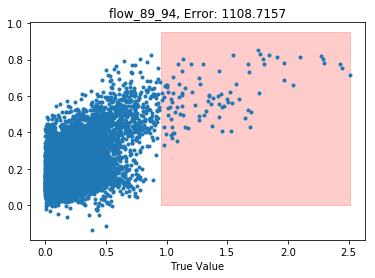

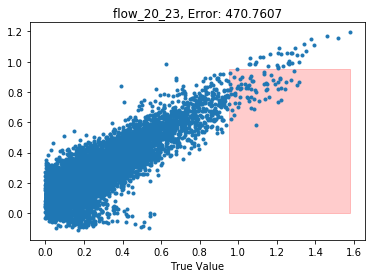

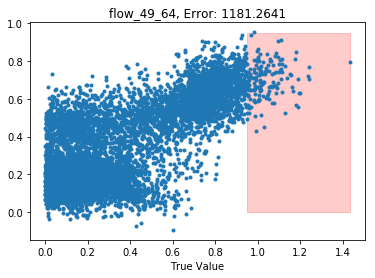

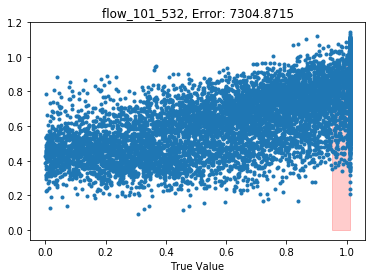

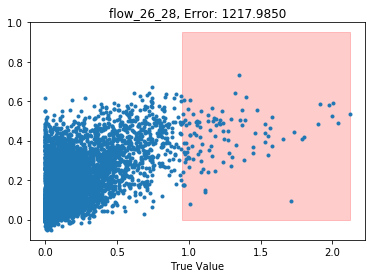

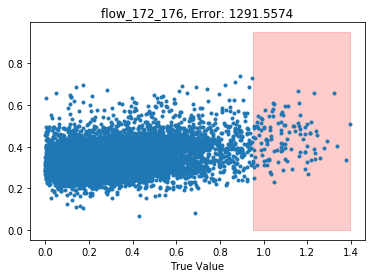

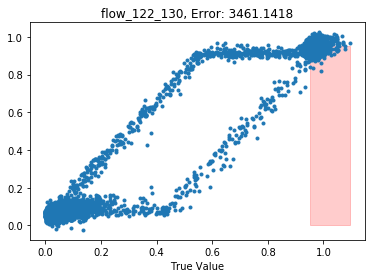

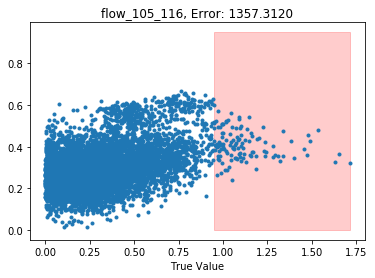

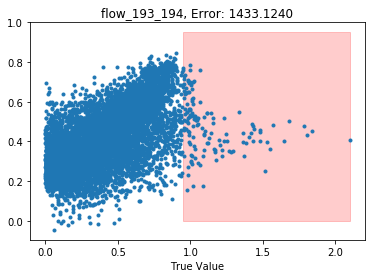

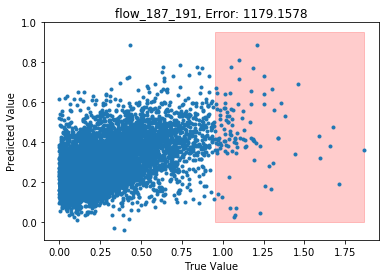

In [5]:
# The code below implements a linear regression on your data and compares predicted and true values.
# On the plots there is a red square indicating the areas corresponding to false negatives.
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(field_data,crit_data)

y_pred = lm.predict(field_data)
for index in range(10):
    plt.figure()
    plt.fill_between([0.95, crit_data.iloc[:,index].max()], [0.95, 0.95], color='r', alpha=0.2)
    plt.plot(crit_data.iloc[:,index],y_pred[:,index],'.')
    error = score_func(y_pred[:,index],crit_data.iloc[:,index])
    plt.title('{0}, Error: {1:.04f}'.format(crit_data.columns[index], error))
    plt.xlabel('True Value')

plt.ylabel('Predicted Value')
print('Overall error: {0:.04f}'.format(score_func(y_pred, crit_data)))


**Q#6** Would you recommend using Linear Regression for estimating line criticality indices? Why/why not?

# Neural Network

You should now produce a neural network that can estimate criticality indices.
Split your data into a training and test set, build your neural network below, and use the score_func defined above to estimate your model quality.

**Q#7** Explain why you chose the layers, nodes and activation functions you did. (No wrong answers, we want to know your thought process!) What is the best score you can get with a single layer?


For the NN Linear regression
We tried using the linear activation function. This gives a slow estimation, but gives a very good approximation. We ended up using the rectified linear activation function "relu", this gives a really quick and consistent estimation, but appears limited in the precission it can reach

We use the optimizer adam, as it is a memory light, computationally efficient algorithm
From reading, the standard parameters of tensorflow, should be pretty good. However we tweaked hte learning rate, to be slightly faster 0.001 -> 0.05. As this gave quick results, but still seem to narrow in on the same result quickly.

We made the neural network, with a single layer, using 10 nodes. We try to keepit simple with small amount of layers. and we get a pretty good approximation using just one layer

using linear, the best score was(however it was very inconsistent)
Epoch 50/50
6648/6648 [==============================] - 0s - loss: 0.1517     
Score:  5386.79165989189

Using relu, the best score was
Epoch 3/3
6648/6648 [==============================] - 0s - loss: 0.2178     
Score:  15613.5309487

**Both results are better than the linear regression function**

In [6]:
# Split data into training and test

# Using the sklearn's builtin function, we split the data, so that 1/5 will be used for testing
# Given a random_state, to make the data reproducable
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(field_data, crit_data, test_size=0.20, random_state=42)

In [7]:
#INSERT Neural Network Code here for a linear regression.
random_state=100
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

model = Sequential()
model.add(Dense(10, input_shape=(20,)))
model.add(Activation('relu'))
adam = optimizers.Adam(lr=0.05, beta_1=0.95,
beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adam)
model.fit(x_train.values,y_train.values,
epochs = 3, batch_size=250, shuffle=False)
y_pred = model.predict(x_test.values, batch_size = 1000)

print("Score: ", score_func(y_pred, y_test))


Using TensorFlow backend.


Epoch 1/3
6648/6648 [==============================] - 0s - loss: 12326.7091      
Epoch 2/3
6648/6648 [==============================] - 0s - loss: 0.2178     
Epoch 3/3
6648/6648 [==============================] - 0s - loss: 0.2178     
Score:  15613.5309487


# K-fold cross validation

To ensure that your neural network actually works when presented with new data, take the neural network you defined above, and perform a k-fold cross validation on it.

**Q#8** Using a test window size of one tenth of your data (ten-fold cross validation), plot a histogram of the output of score_func for the validation. Tweak your neural network to achieve the lowest mean score.H

In [64]:
# Your k-fold code goes here.

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

listOfErrors2 = list()
kf1 = KFold(n_splits=10,shuffle=True)
for train_index, test_index in kf1.split(field_data):
    X_train, X_test = field_data.iloc[train_index], field_data.iloc[test_index]
    Y_train, Y_test = crit_data.iloc[train_index], crit_data.iloc[test_index]
    #print(X_test)
    model = Sequential()
    model.add(Dense(10, input_shape=(20,)))
    model.add(Activation('relu'))
    
    adam = optimizers.Adam(lr=0.05, beta_1=0.95,
                            beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=adam)
    history1 = model.fit(x_train.values,y_train.values, epochs=3, batch_size=250, shuffle=True)
    y_pred2 = model.predict(x_test.values, batch_size=1000)
    listOfErrors2.append(score_func(y_pred2, y_test))

Epoch 1/3
6648/6648 [==============================] - 1s - loss: 11234.1006      
Epoch 2/3
6648/6648 [==============================] - 0s - loss: 0.2178     
Epoch 3/3
6648/6648 [==============================] - 0s - loss: 0.2178     
Epoch 1/3
6648/6648 [==============================] - 0s - loss: 10952.6376      
Epoch 2/3
6648/6648 [==============================] - 0s - loss: 0.2178     
Epoch 3/3
6648/6648 [==============================] - 0s - loss: 0.2178     
Epoch 1/3
6648/6648 [==============================] - 0s - loss: 13270.1391      
Epoch 2/3
6648/6648 [==============================] - 0s - loss: 0.2178     
Epoch 3/3
6648/6648 [==============================] - 0s - loss: 0.2178     
Epoch 1/3
6648/6648 [==============================] - 0s - loss: 38044.7376      
Epoch 2/3
6648/6648 [==============================] - 0s - loss: 0.2178     
Epoch 3/3
6648/6648 [==============================] - 0s - loss: 0.2178     
Epoch 1/3
6648/6648 [=======================

In [8]:


plt.hist(listOfErrors2)
plt.grid(True)
plt.show()

print("Mean score: " , np.mean(listOfErrors2))
print("KFold scores: ", listOfErrors2)



NameError: name 'listOfErrors2' is not defined

In [19]:
# k-fold of the linear version

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

listOfErrors2 = list()
kf1 = KFold(n_splits=10,shuffle=True)
for train_index, test_index in kf1.split(field_data):
    X_train, X_test = field_data.iloc[train_index], field_data.iloc[test_index]
    Y_train, Y_test = crit_data.iloc[train_index], crit_data.iloc[test_index]
    #print(X_test)
    model = Sequential()
    model.add(Dense(10, input_shape=(20,)))
    model.add(Activation('linear'))
    model.add(Dense(10,))
    model.add(Activation('linear'))
    
    adam = optimizers.Adam(lr=0.009, beta_1=0.85,
                            beta_2=0.999, epsilon=1e-001, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=adam)
    history1 = model.fit(x_train.values,y_train.values, epochs=50, batch_size=100, shuffle=True)
    y_pred2 = model.predict(x_test.values, batch_size=1000)
    listOfErrors2.append(score_func(y_pred2, y_test))

Epoch 1/50
6648/6648 [==============================] - 0s - loss: 34855.0576     
Epoch 2/50
6648/6648 [==============================] - 0s - loss: 1011.0088     
Epoch 3/50
6648/6648 [==============================] - 0s - loss: 313.9042     
Epoch 4/50
6648/6648 [==============================] - 0s - loss: 148.0342     
Epoch 5/50
6648/6648 [==============================] - 0s - loss: 85.5130     
Epoch 6/50
6648/6648 [==============================] - 0s - loss: 54.7495     
Epoch 7/50
6648/6648 [==============================] - 0s - loss: 37.1201     
Epoch 8/50
6648/6648 [==============================] - 0s - loss: 26.0638     
Epoch 9/50
6648/6648 [==============================] - 0s - loss: 18.6907     
Epoch 10/50
6648/6648 [==============================] - 0s - loss: 13.6790     
Epoch 11/50
6648/6648 [==============================] - 0s - loss: 10.2136     
Epoch 12/50
6648/6648 [==============================] - 0s - loss: 7.7882     
Epoch 13/50
6648/6648 [========

6648/6648 [==============================] - 0s - loss: 1094.9492     
Epoch 4/50
6648/6648 [==============================] - 0s - loss: 518.9189     
Epoch 5/50
6648/6648 [==============================] - 0s - loss: 272.4274     
Epoch 6/50
6648/6648 [==============================] - 0s - loss: 151.6361     
Epoch 7/50
6648/6648 [==============================] - 0s - loss: 88.2364     
Epoch 8/50
6648/6648 [==============================] - 0s - loss: 52.7075     
Epoch 9/50
6648/6648 [==============================] - 0s - loss: 32.3673     
Epoch 10/50
6648/6648 [==============================] - 0s - loss: 20.6663     
Epoch 11/50
6648/6648 [==============================] - 0s - loss: 13.7193     
Epoch 12/50
6648/6648 [==============================] - 0s - loss: 9.3916     
Epoch 13/50
6648/6648 [==============================] - 0s - loss: 6.7532     
Epoch 14/50
6648/6648 [==============================] - 0s - loss: 5.0674     
Epoch 15/50
6648/6648 [=====================

6648/6648 [==============================] - 0s - loss: 75.1784     
Epoch 6/50
6648/6648 [==============================] - 0s - loss: 47.1238     
Epoch 7/50
6648/6648 [==============================] - 0s - loss: 31.9689      ETA: 0s - loss: 33.00
Epoch 8/50
6648/6648 [==============================] - 0s - loss: 22.5693     
Epoch 9/50
6648/6648 [==============================] - 0s - loss: 16.2834     
Epoch 10/50
6648/6648 [==============================] - 0s - loss: 12.0306     
Epoch 11/50
6648/6648 [==============================] - 0s - loss: 8.9828     
Epoch 12/50
6648/6648 [==============================] - 0s - loss: 6.7331     
Epoch 13/50
6648/6648 [==============================] - 0s - loss: 5.1660     
Epoch 14/50
6648/6648 [==============================] - 0s - loss: 3.9662     
Epoch 15/50
6648/6648 [==============================] - 0s - loss: 3.0891     
Epoch 16/50
6648/6648 [==============================] - 0s - loss: 2.4156     
Epoch 17/50
6648/6648 [=====

6648/6648 [==============================] - 0s - loss: 21.7004      ETA: 0s - loss: 2
Epoch 8/50
6648/6648 [==============================] - 0s - loss: 14.7286     
Epoch 9/50
6648/6648 [==============================] - 0s - loss: 10.4593     
Epoch 10/50
6648/6648 [==============================] - 0s - loss: 7.7516     
Epoch 11/50
6648/6648 [==============================] - 0s - loss: 5.9424     
Epoch 12/50
6648/6648 [==============================] - 0s - loss: 4.7227     
Epoch 13/50
6648/6648 [==============================] - 0s - loss: 3.7353     
Epoch 14/50
6648/6648 [==============================] - 0s - loss: 3.0602     
Epoch 15/50
6648/6648 [==============================] - 0s - loss: 2.5337     
Epoch 16/50
6648/6648 [==============================] - 0s - loss: 2.1456     
Epoch 17/50
6648/6648 [==============================] - 0s - loss: 1.8442     
Epoch 18/50
6648/6648 [==============================] - 0s - loss: 1.6600     
Epoch 19/50
6648/6648 [==========

6648/6648 [==============================] - 0s - loss: 17.5223     
Epoch 9/50
6648/6648 [==============================] - 0s - loss: 12.1952     
Epoch 10/50
6648/6648 [==============================] - 0s - loss: 8.8680     
Epoch 11/50
6648/6648 [==============================] - 0s - loss: 6.5203     
Epoch 12/50
6648/6648 [==============================] - 0s - loss: 4.8873     
Epoch 13/50
6648/6648 [==============================] - 0s - loss: 3.6868     
Epoch 14/50
6648/6648 [==============================] - 0s - loss: 2.8095     
Epoch 15/50
6648/6648 [==============================] - 0s - loss: 2.1474     
Epoch 16/50
6648/6648 [==============================] - 0s - loss: 1.6348     
Epoch 17/50
6648/6648 [==============================] - 0s - loss: 1.2481     
Epoch 18/50
6648/6648 [==============================] - 0s - loss: 0.9501     
Epoch 19/50
6648/6648 [==============================] - 0s - loss: 0.7258     
Epoch 20/50
6648/6648 [============================

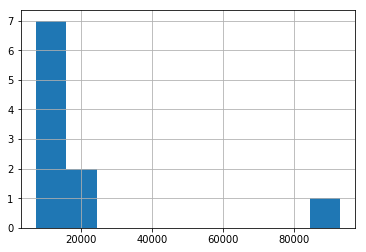

Mean score:  20928.5348776
KFold scores:  [10963.364549959259, 13219.340977444715, 93156.21636866506, 7302.5751914463171, 23743.659999042266, 23792.280450787286, 14628.356687323529, 7793.8402410700091, 7121.8540383414747, 7563.860272220285]


In [20]:
plt.hist(listOfErrors2)
plt.grid(True)
plt.show()

print("Mean score: " , np.mean(listOfErrors2))
print("KFold scores: ", listOfErrors2)


**Q#9** Are you satisfied with the quality of the final estimator? What would be your recommendation for your boss on this issue?

*Using the relu activation function, gives fast and consisten estimations, though they are limited in their precision.*

*However the linear activation function gives great precision, but requires many iterations, and therefore a lot more time, and is not very consistent. Possible you can tune the values, and get some consistent high-precision results.*

*The problem using relu, is that it is not differentiable in zero, and this data has a lot of zero's therefore it will not learn well.*

# Extra task for 3-person groups

**Q#10** Repeat the process, once reducing to 15 sensors, and once reducing to 25 sensors. The costs to keep these sensors running is directly proportional to the number of sensors used. Does changing the number of sensors used change your conclusion in Q#9?

**We are only 2 people**